# Tutorial `TauREx3` retrievals

*Author: Quentin Changeat (University College London)*

For this tutorial, you need:
- `TauREx3.1`. 
- `taurex-ace`.

These codes can be installed doing ``pip install taurex`` and ``pip install taurex-ace`` in a command line. Before doing this, I encourage you to create a new conda environment, which allows better control of the installed libraries and dependencies. Anaconda is available at: https://repo.anaconda.com/



### General Setup

Let's first import some useful libraries and disable the TauREx logs to hide intermediary messages. The command is:

```
taurex.log.disableLogging()
```


In [39]:
import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import *
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()

TauREx needs input opacity data, such as cross sections for computing molecular absorptions and collision induced absorption (CIA)

The input files can be downloaded at:

*https://liveuclac-my.sharepoint.com/:f:/g/personal/ucapqch_ucl_ac_uk/Eupk2usw2e1ArmgluzbJ_XMBEO8q8daAZEhqdMxHxs817A?e=Fyk95l*.

Let's now set up the TauREx caches.

In [40]:
### --> We load the cross section and cia information.
# Those are tables characterising the absorption of each species in the atmosphere
# They depends on wavelengths, temperature and pressure.
from taurex.cache import OpacityCache,CIACache
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("/Users/quentinc/Documents/Codes/Inputs/xsec/taurex3_xsec_hdf5_sampled_R15000_0.3-50_2021MAY")
CIACache().set_cia_path("/Users/quentinc/Documents/Codes/Inputs/cia/hitran")


### Planet and Star objects

For a transmission or an eclipse model, you need to define the characteristics of your system. So, we create a planet and a star.

The simplest planet is called `Planet` and it has two parameters:
- planet_radius in Jupiter radius
- planet_mass in Jupiter mass

For the star, we will use a `BlackbodyStar`, which has three parameters of interest:
- temperature in K
- radius in Sun radius
- mass in Sun mass

In [41]:
#PLANET
from taurex.planet import Planet
planet = Planet(planet_radius=1,planet_mass=1, albedo=0)

#STAR
from taurex.stellar import BlackbodyStar
star = BlackbodyStar(temperature=6000,radius=1,mass=1)

### Atmosphere

For TauREx to compute a spectrum, the properties of the atmosphere must be described. These include the temperature profile and the chemistry profile.

##### Temperature

For the temperature profile, many options are available such as `Isothermal`, `NPoint` or `Guillot`. 

First, an example with `NPoint`:

In [42]:
from taurex.temperature import NPoint
NPoint = NPoint(T_surface=1200.0, T_top=800, P_surface=1e6, P_top=1e0, pressure_points=[1e3,], 
                temperature_points=[1000,])

For this test, we will just use an isothermal. This can be justified in transmission by the fact that the atmospheric signal is most affected by the scale height.

In [43]:

from taurex.temperature import Isothermal
isothermal = Isothermal(T=1200.0)

##### Chemistry

For the chemistry, again, many options are offered. See Olivia's tutorial for more information but a few examples include:
- TauREx free chemistry
- Equilibrium ACE, via the plugin `taurex-ace`
- Equilibrium GGChem, via the plugin `taurex-ggchem`
- Equilibrium FastChem, via the plugin `taurex-fastchem`
- Dis-equilibrium, via the plugin `pychgp`

Let's start with a standard free chemistry model:

The TauREx free chemistry is first setup by defining the main fill gases. These gases will fill-in the atmosphere once the trace gases are defined.

More than two gases can fill the atmosphere, with their ratios always being the ratios to the 1st compounds. Here is an example of a typical hydrogen dominated atmosphere:

In [44]:
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=[0.17,])

Now, trace gases can be added to the chemistry using the function ``addGas()``. In this function, a profile type is passed such as ``ConstantGas`` for constant with altitude profiles or ``TwoLayerGas`` for more flexibility.


In [17]:
from taurex.chemistry import ConstantGas
from taurex.chemistry import TwoLayerGas
chemistry.addGas(ConstantGas('H2O',mix_ratio=1e-3))
chemistry.addGas(ConstantGas('CH4',mix_ratio=1e-4))
chemistry.addGas(ConstantGas('CO2',mix_ratio=1e-6))
chemistry.addGas(ConstantGas('CO',mix_ratio=1e-2))
chemistry.addGas(ConstantGas('N2',mix_ratio=1e-2))


Gases that have cross sections in the ``OpacityCache`` are designed as ``activeGases``, while the other ones are ``inactiveGases``.

In [18]:
print('Active gases:', chemistry.activeGases)
print('Inactive gases:', chemistry.inactiveGases)

Active gases: ('H2O', 'CH4', 'CO2', 'CO')
Inactive gases: ('H2', 'He', 'N2')


But now, for the fun, we want to try a more complex atmosphere, so we will go for an equilibrium chemistry code, let's say ACE. ACE can be made available as a plugin using the command: 

```
pip install taurex-ace
```

Then, this can be imported from the new library ``taurex_ace``:

In [19]:
from taurex_ace import ACEChemistry
chemistry = ACEChemistry(metallicity=1)

In [20]:
print('Active gases:', chemistry.activeGases)
print('Inactive gases (only the first 5):', chemistry.inactiveGases[:5])
print('Number of species included: ', len(chemistry.gases))

Active gases: ('CO2', 'HCN', 'NH3', 'CH4', 'CO', 'H2O')
Inactive gases (only the first 5): ('CH3COOOH', 'C4H9O', 'C3H7O', 'NO3', 'CH3COOO')
Number of species included:  105


### Model and Contributions

Now, we have everything to prepare the atmospheric model. We can choose the type of observation we want from ``TransmissionModel`` to ``EmissionModel``. For example, for an emission the model can be defined by:

```
from taurex.model import EmissionModel
tm = EmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-2,
                       atm_max_pressure=1e6,
                       nlayers=100)
```

But since we are interested in Transmission, let's do:

In [21]:

from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-2,
                       atm_max_pressure=1e6,
                       nlayers=100)


We now need to define th physics we want to include in our model. For example, we can add molecular absorption to make use of the chemistry calculated by ``taurex-ace``. This requires to have the molecular cross-sections loaded in the Cache. 
Let's enable molecular absorption using the ``AbsorptionContribution()`` contribution:

In [22]:
##add absorption contributions
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

Another contribution to consider is Collision Induced Absorption, enabled via ``CIAContribution()``. This requires to have the CIA files loaded in the Cache, and can be enabled via:

In [23]:
##add cia contributions
from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

We can also add Rayleigh scattering, computed automatically from the species available in the mode with the ``RayleighContribution()`` contribution:

In [24]:

##add rayleigh contributions
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

Finally, for this model, we will add some simple grey cloud ``SimpleCloudsContribution()`` providing a fully opaque layer bellow a cloud deck.

In [25]:
##add clouds contribution. Clouds pressure is in Pa
from taurex.contributions import SimpleCloudsContribution
tm.add_contribution(SimpleCloudsContribution(clouds_pressure=1e4))

### Running the model

The model is now ready to be built. This will setup connections between the relevant classes and initialise them. For example, the ``Chemistry`` class needs to know on how many layers to run, or it also needs a ``Pressure`` profile. All these informations are passed in at this stage.

In [26]:
tm.build()

The model being built successfully. Since we are talking about retrievals, interesting parameters we might want to fit for, designed as ``fittingParameters``, are now accessible: 

In [27]:
print('list of fittingParameters:', tm.fittingParameters.keys())

list of fittingParameters: dict_keys(['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'T', 'ace_metallicity', 'metallicity', 'ace_co', 'C_O_ratio', 'clouds_pressure'])


This list can also be accessed via command line by typing:

```
taurex --fitparams
```

For fun, we can now update any of those parameters very easilly. For example, I want to change the temperature from  1200K to 1500K:

In [28]:
print('Previous Temperature: ', tm['T'])
tm['T'] = 1500.
print('Previous Temperature: ', tm['T'])

Previous Temperature:  1200.0
Previous Temperature:  1500.0


OK, cool. But let's run the model and store the results to see what the spectrum looks like:

In [29]:
res = tm.model()

### Plot the model

The results are stored in the variable ``res``. We can unpack this tuple and do a simple plot of the spectrum. 
In TauREx, the units for wavelength is wavenumber, but you might be more familiar with wavelength, so we can convert before plotting.

<IPython.core.display.Javascript object>


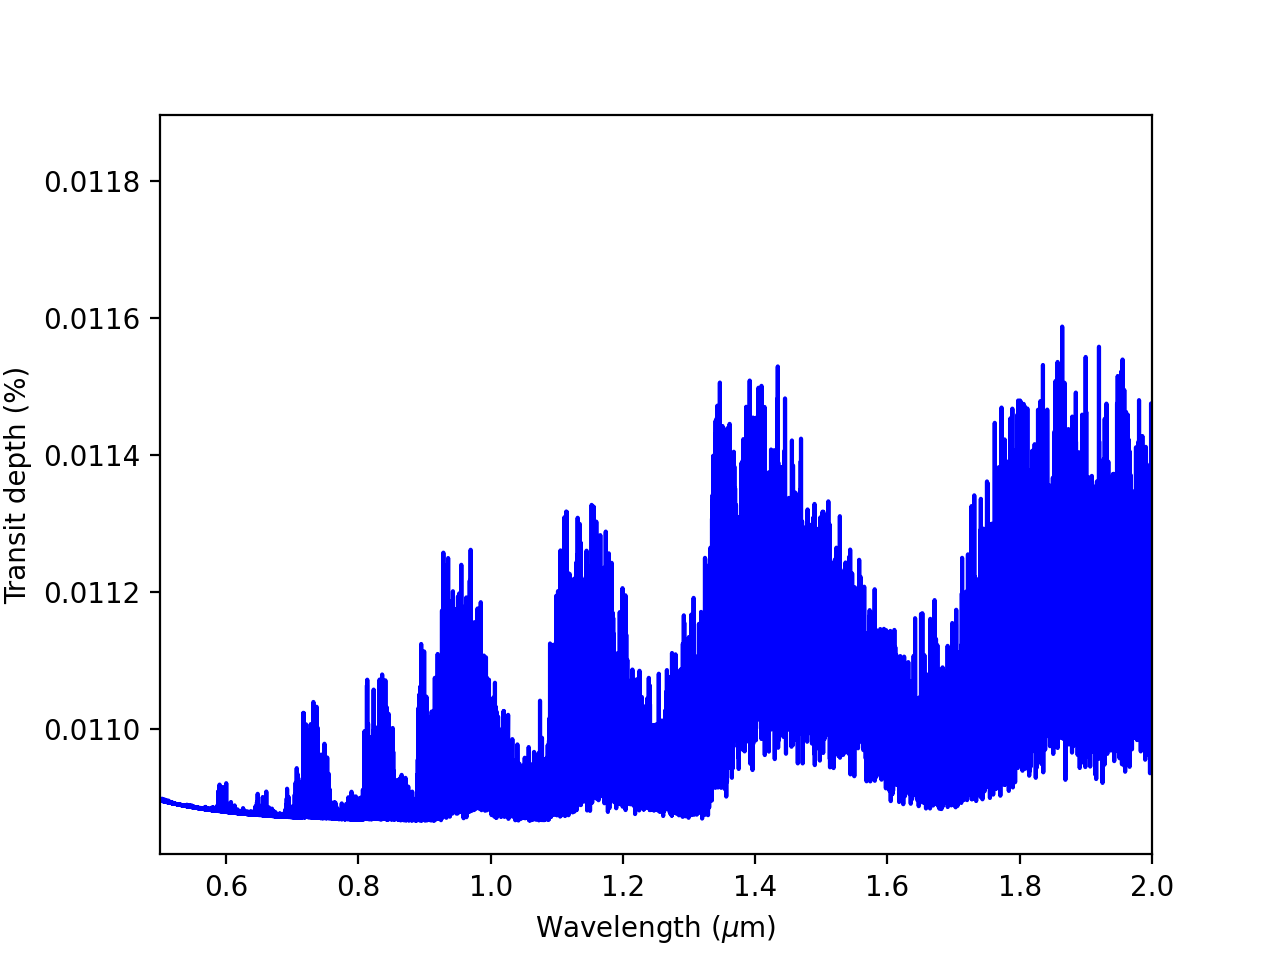

In [30]:
### --> Let's plot how it looks like:
native_grid, rprs, tau, _ = res
### native grid is in wavenumber by convention. But since I like to work in wavelengths I can convert it.
native_grid_wl = 10000/native_grid

plt.figure()
plt.plot(native_grid_wl, rprs, color='blue')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (%)')
plt.xlim(0.5, 2)
plt.show()

The result of the forward model is provided at native resolution, and it can be had to see what is going on here. To work at a lower resolution, we can bin down the result using convenient functions from ``TauREx``. Let's start by getting a new wavelength grid at resolution 80 between 1.1 and 1.6um, with the ``create_grid_res`` function. This is as simple as:

In [31]:
from taurex.util.util import create_grid_res
lowres_grid = create_grid_res(80, 1.1, 1.6)

We can now use the ``FluxBinner`` to bin down our high resolution spectrum to this new grid. We first initialise the binner, passing in the wavelenght and binwidth grids:

In [32]:
from taurex.binning import FluxBinner
fb = FluxBinner(lowres_grid[:,0], lowres_grid[:,1])

The binner can then be used on the high resolution spectrum via the ``bindown()`` function. There is also a ``bin_model()`` function, which takes in the results of the ``model()`` (here it would be res). For the ``bindown()`` function, quantities must be sorted in incresing wavelengths:

In [33]:
lowres_spectrum = fb.bindown(native_grid_wl[::-1], rprs[::-1])

<IPython.core.display.Javascript object>


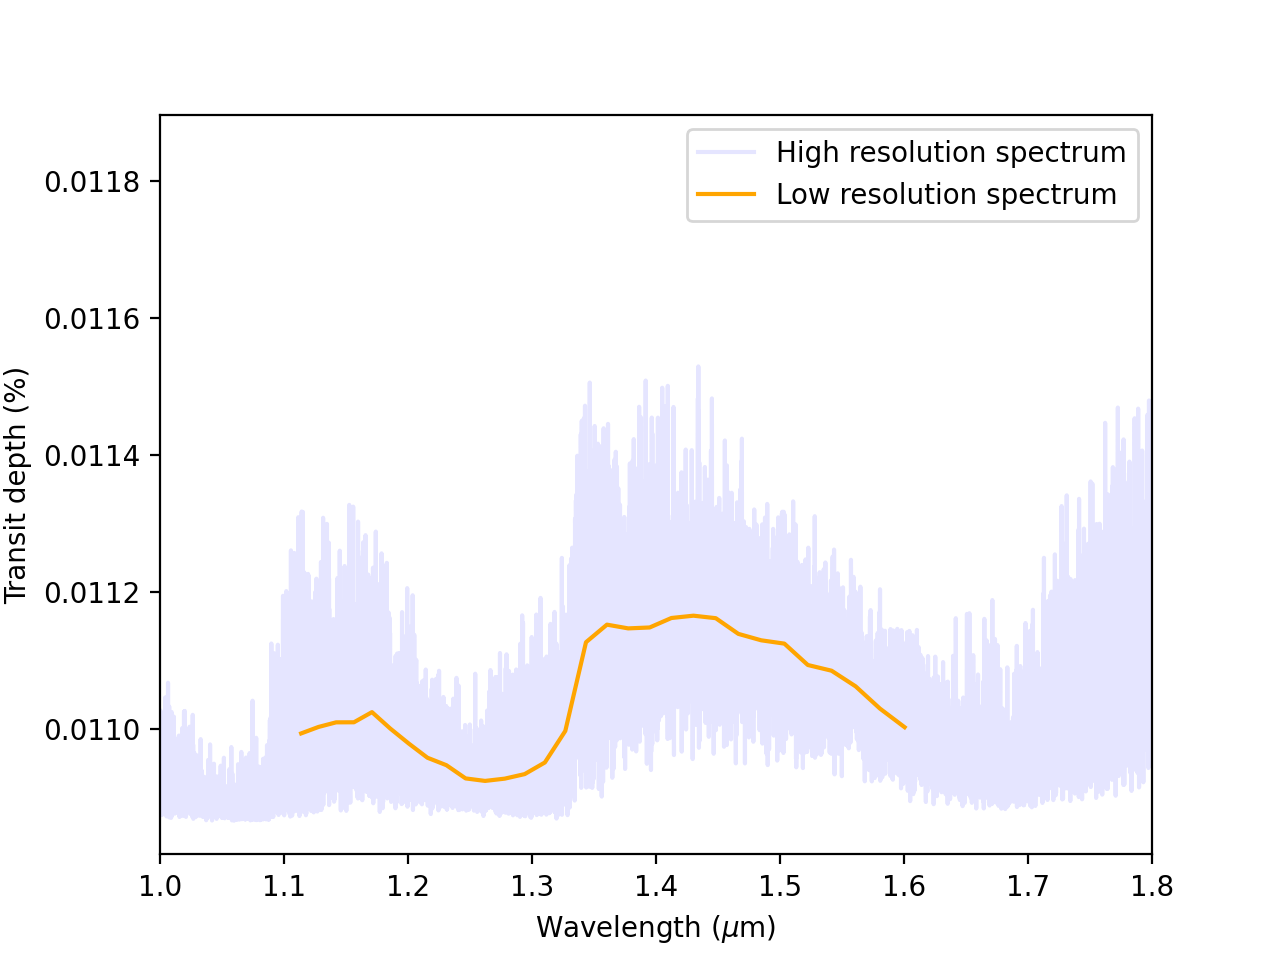

In [34]:
## Now a small plot to check we do this right:
plt.figure()
plt.plot(native_grid_wl, rprs, color='blue',alpha=0.1, label='High resolution spectrum')
plt.plot(lowres_spectrum[0], lowres_spectrum[1], color='orange', label='Low resolution spectrum')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (%)')
plt.legend()
plt.xlim(1.0,1.8)
plt.show()

All quantities of interest can be extracted from the model directly. For example, if we want to plot the temperature profile we just used:

<IPython.core.display.Javascript object>


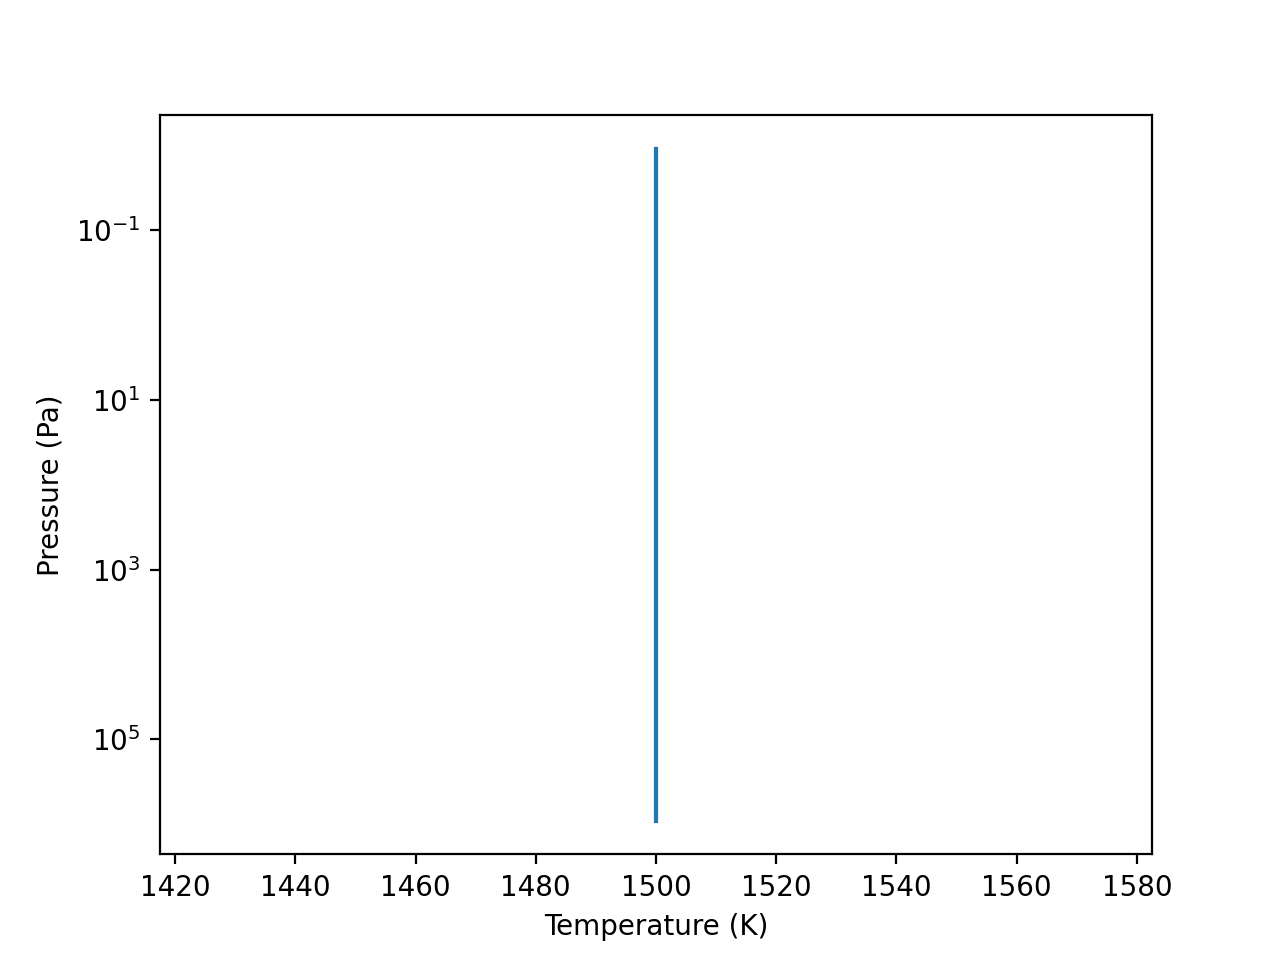

In [38]:
plt.figure()
plt.plot(tm.temperature.profile, tm.pressure.profile)
plt.yscale('log')
plt.gca().invert_yaxis()
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.show()

### Creating new features with the TauREx 3.1 plugin system

TauREx 3.1 instroduces a new plugin system. Plugins are external enhancements to the TauREx code that allow fast and flexible development. 

The chemistry ``taurex-ace`` for instance, is a plugin. It can be developed independently from the main ``TauREx`` code, without risking to break the main functionalities. Plugins can automatically interact, meaning that the system eliminates the need to track individual variables through an ever growing spagetti code.

We will now quickly learn how to build new plugins. First, we can access the list of installed plugins by typing in command line:

```
taurex --plugins
```

For this example, we just do a thermal profile that has a random value. This is absolutely not realistic and makes no sense, but I will use this to illustrate how plugins work. The input parameters of our profile are going to be the mean and standard deviation from which to get the profile:
- mean
- std

TauREx can read those from the ``__init__()`` function.

In this example I also want to enable fitting for the parameter 'mean', because I can! This is done easilly by importing the ``fitparam`` decorator, which allows to create the getter and setter functions that are accessed by TauREx to get and set the parameter during the retrievals.

Now for a temperature profile, it must inherit from the generic TauREx class called TemperatureProfile. This class requires to define a ``profile()`` function. This is done here by just randomly generating the value for the temperature.

The write function is a function that allows TauREx to save some of the variables of the class in the final .hdf5 files.

And finally the ``input_keywords()`` class allows to use this profile with the parfiles.

In [107]:
from taurex.temperature import TemperatureProfile
import numpy as np
from taurex.data.fittable import fitparam


class RandomTemperatureProfile(TemperatureProfile):
    """A random isothermal temperature-pressure profile
    """

    ### Initializing the new class
    def __init__(self, mean = 1000, std = 200):
        super().__init__('Equilibrium')
        self._mean = mean
        self._std = std
    
    ### Defining the get and set function for the fitting parameter 'mean'
    @fitparam(param_name='Tmean',
              param_latex='$Tmean$',
              default_fit=False,
              default_bounds=[300.0, 2000.0])
    def meanTemperature(self):
        return self._mean
    
    @meanTemperature.setter
    def meanTemperature(self, value):
        self._mean = value
    
    ### The key of this class, this provides the temperature profile.
    ### This 'profile()' function is mandatory for all classes inheriting from the TemperatureProfile class.
    @property
    def profile(self):
        """Returns a random temperature profile
        """
        self.T = np.maximum(np.random.normal(self._mean, self._std), 10.0)
        T = np.zeros((self.nlayers))
        T[:] = self.T

        return T

    ### This is to tell TauREx what outputs to save
    def write(self, output):
        temperature = super().write(output)
        temperature.write_scalar('mean', self._mean)
        temperature.write_scalar('std', self._std)
        temperature.write_scalar('T', self.T)
        return temperature

    ### This is the keyword to use in the parfile
    @classmethod
    def input_keywords(cls):
        return ['random_tp', ]

Let's use our new class in TauREx directly. In the next cell, we create, build, run and plot the model twice to show the differences. Re-running this cell will always lead to different results, since the temperature profile is generated randomly.

<IPython.core.display.Javascript object>


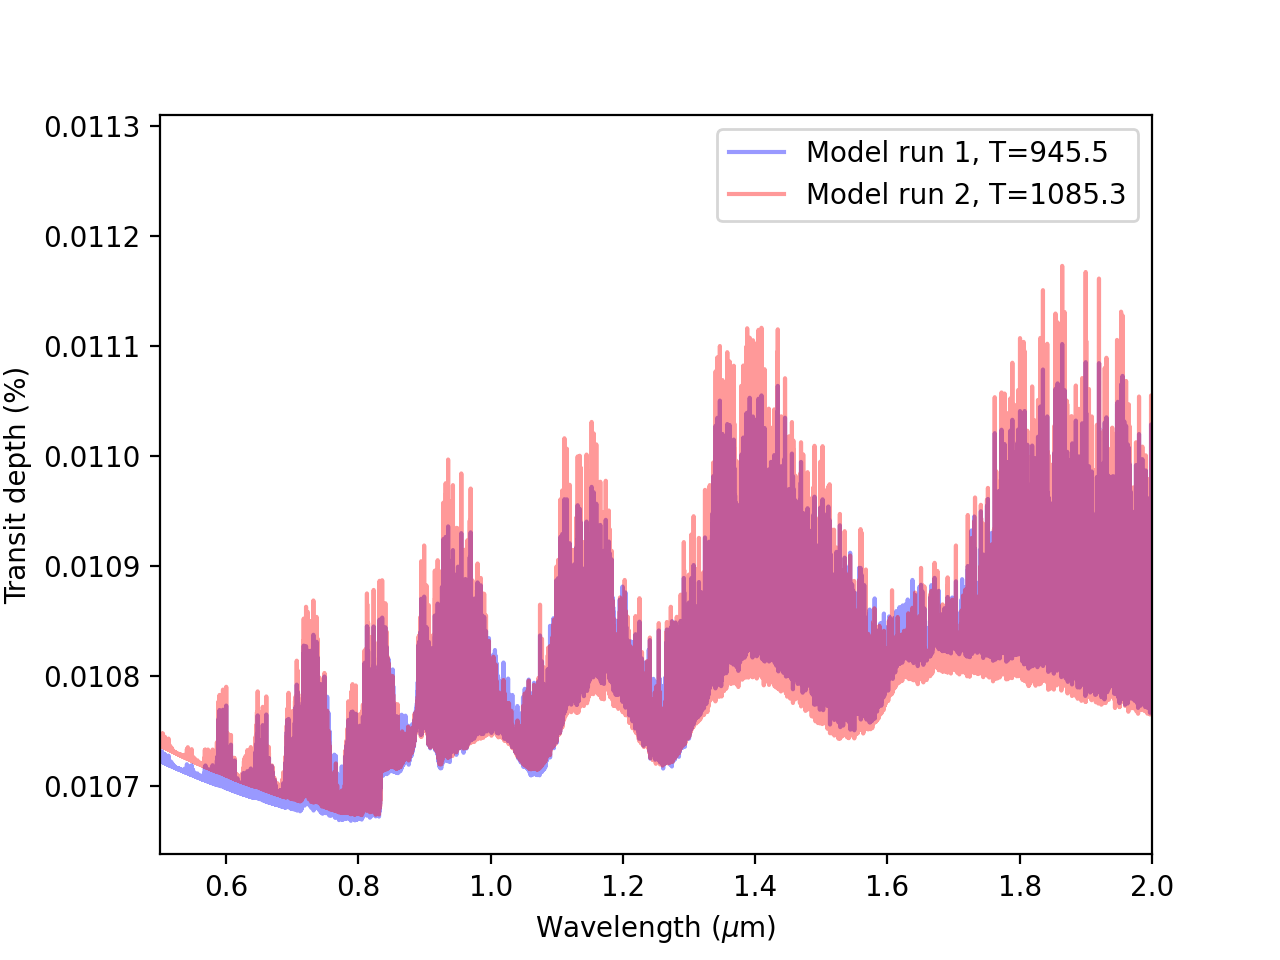

In [113]:
randomtp = RandomTemperatureProfile()
from taurex.model import TransmissionModel
tm2 = TransmissionModel(planet=planet,
                       temperature_profile=randomtp,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-2,
                       atm_max_pressure=1e6,
                       nlayers=100)
tm2.add_contribution(AbsorptionContribution())
tm2.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm2.add_contribution(RayleighContribution())
tm2.build()
res2 = tm2.model()
tp2 = tm2.temperature.T
# running a second time
res3 = tm2.model()
tp3 = tm2.temperature.T

plt.figure()
plt.plot(10000/res2[0], res2[1], color='blue', label='Model run 1, T='+str(int(tp2*10)/10), alpha=0.4)
plt.plot(10000/res3[0], res3[1], color='red', label='Model run 2, T='+str(int(tp3*10)/10), alpha=0.4)
plt.legend()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (%)')
plt.xlim(0.5, 2)
plt.show()

For the fun, let's just check that Tmean is retrievable.

In [116]:
print('fittingParameters: ',tm2.fittingParameters.keys())

fittingParameters:  dict_keys(['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'Tmean', 'ace_metallicity', 'metallicity', 'ace_co', 'C_O_ratio'])


Ok, now that we are super happy with our new temperature profile, we can turn this into an installable plugin.
The plugin can be hosted anywhere (pypi, github...). It will have the following file hierarchy:

<code>
->.setup.py
->taurex_randomtp
    ---> .\_\_init\_\_.py
    ---> .randomtp.py
</code>

Here is a description of the files we just created:

- The file ``randomtp.py`` contains the code of the new class we just build. 
- The file ``\_\_init\_\_.py`` just contains the link to discover the class, so in our case it must include ``from .randomtp.py import RandomTemperatureProfile``.
- The file ``setup.py`` links the plugin to TauREx 3.1

The file setup.py will have the following code:

<code>
    import setuptools
    from setuptools import find_packages
    from numpy.distutils.core import setup
    from numpy.distutils.core import Extension
    from numpy.distutils import log
    import re, os
    packages = find_packages(exclude=('tests', 'doc'))
    provides = ['taurex_randomtp', ]
    requires = []
    install_requires = ['taurex']
    entry_points = {'taurex.plugins': 'taurex_randomtp = taurex_randomtp'}
    setup(name='taurex_randomtp',
          author="Quentin Changeat",
          author_email="tbd",
          license="BSD",
          description='Extra cool random tp for taurex',
          packages=packages,
          entry_points=entry_points,
          provides=provides,
          requires=requires,
          install_requires=install_requires) 
</code>

Now the plugin can be installed using ``pip install .`` from the directory where ``setup.py`` is located and the class is fully usable in TauREx.

### A Fake instrument simulator

In the next cell, the same code structure is used to create an instrument that can be used with TauREx. Note that TauREx handles instruments automatically, so, following the same steps as in the previous section, the new class can be made as a plugin. 

This new class will help us simulate some observations using a fake instrument. The instrument is defined by:
- Wavelength coverage (parameters ``wl_min`` and ``wl_max``)
- Resolution (parameter ``resolution``)
- Noise in ppm (parameter ``noise``)
- Scatter as True or False (parameter ``scatter``)


In [121]:
from taurex.instruments import Instrument
import numpy as np
import math


class UniformResolutionInstrument(Instrument):
    """

    Simple instrument model that bins to a given resolution.

    Parameters
    ----------

    noise: float in ppm
        Noise on one observation in ppm

    wl_min: float in um
        Minimum wavelength of the instrument
        
    wl_min: float in um
        Maximum wavelength of the instrument

    resolution:
        Resolution of the instrument
        
    """
    def __init__(self, noise=10, wl_min = 1.1, wl_max=1.6, resolution=80, scatter=False):
        super().__init__()

        self._noise = noise*1e-6
        self._wl_min = wl_min
        self._wl_max = wl_max
        self._resolution = resolution
        self._scatter = scatter
        
        from taurex.binning import FluxBinner
        from taurex.util.util import create_grid_res
        grid = create_grid_res(resolution, 10000/wl_max, 10000/wl_min)
        self._binner = FluxBinner(grid[:,0], grid[:,1])
    
    ### This is the only mandatory function for a class of type Instrument.
    def model_noise(self, model, model_res=None, num_observations=1):

        if model_res is None:
            model_res = model.model()

        binner = self._binner

        wngrid, spectrum, error, grid_width = self._binner.bin_model(model_res)
        
        self.spectrum = spectrum
        instance_noise = self._noise / math.sqrt(num_observations)
        
        if self._scatter:
            spectrum = np.random.normal(self.spectrum, instance_noise)
        
        return wngrid, spectrum, \
            instance_noise, grid_width

    @classmethod
    def input_keywords(cls):
        return ['uni_instrument']

Let's use our new class. The outputs of TauREx can directly be passed in using the function ``model_noise``.

In [119]:
inst = UniformResolutionInstrument(noise=30, wl_min = 1.1, wl_max=1.6, resolution=80, scatter=True)
output = inst.model_noise(tm, num_observations=1)


<IPython.core.display.Javascript object>


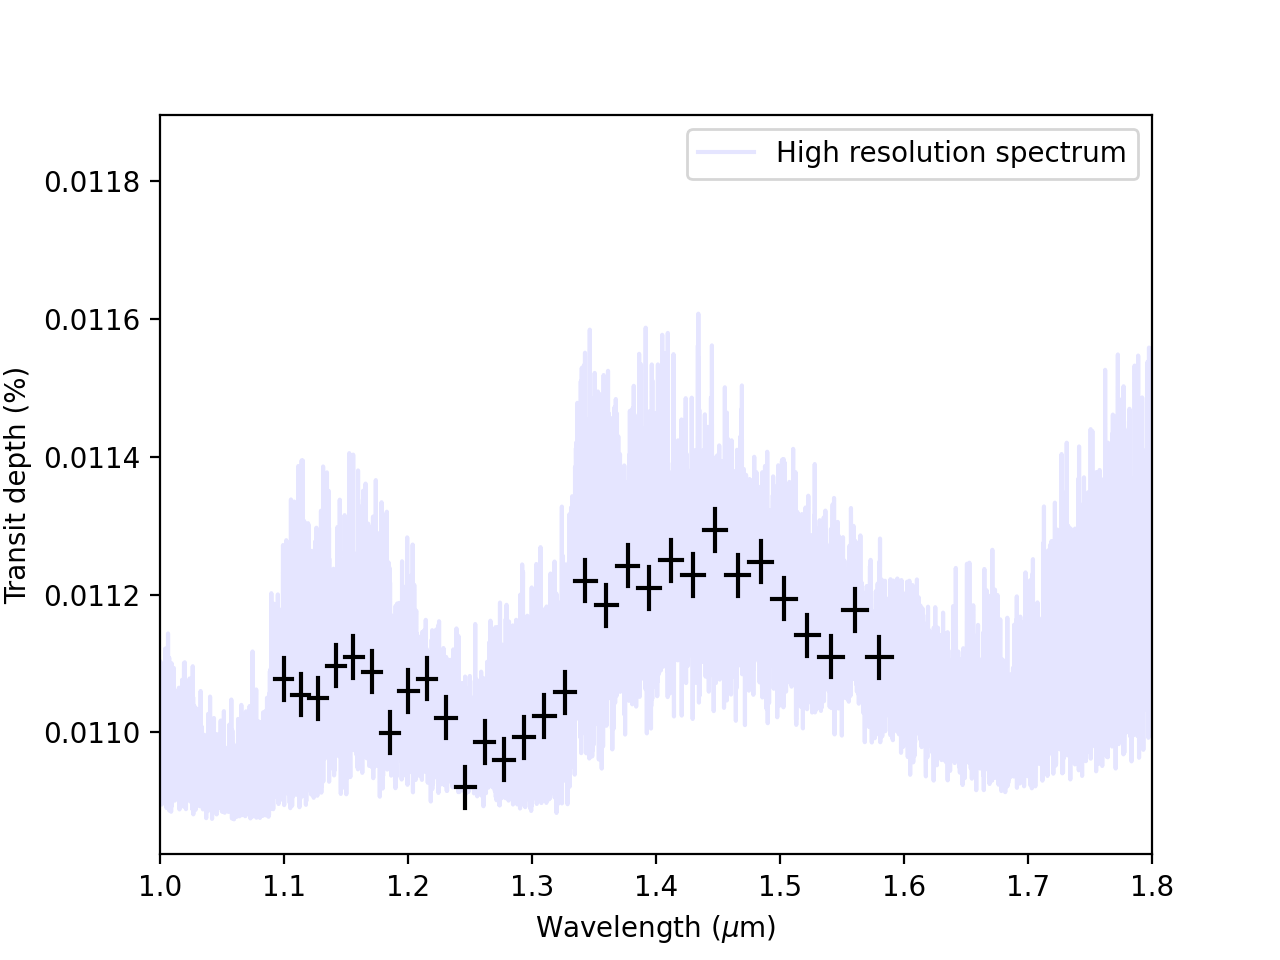

In [120]:
plt.figure()
plt.plot(native_grid_wl, rprs, color='blue', alpha=0.1, label='High resolution spectrum')
plt.plot((10000/output[0], 10000/output[0]), (output[1]-output[2], output[1]+output[2]), color='black')
plt.plot((10000/(output[0]-output[3]/2), 10000/(output[0]+output[3]/2)), (output[1], output[1]), color='black')
plt.legend()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit depth (%)')
plt.xlim(1.0,1.8)
plt.show()

The observed spectrum can be saved to the standard TauREx format for further use.

In [122]:
my_spectrum_output = np.zeros((len(output[0]),4))
my_spectrum_output[:,0] = 10000/output[0]
my_spectrum_output[:,1]  = output[1]
my_spectrum_output[:,2] = output[2]
my_spectrum_output[:,3] = output[3]

np.savetxt('Outputs/my_spectrum_output.txt', my_spectrum_output)

### Setup a retrieval

First for performing an atmospheric retrieval, we need an observation. Here we will just use the spectrum we just created. We can use the ``ArraySpectrum`` class if we already have an array.

In [124]:
from taurex.data.spectrum import ArraySpectrum
obs = ArraySpectrum(my_spectrum_output)

We can also load directly from the file with the ``ObservedSpectrum()`` class.

In [125]:
from taurex.data.spectrum import ObservedSpectrum
obs = ObservedSpectrum(filename = 'Outputs/my_spectrum_output.txt')

Now that we have a valid observation, we must choose an optimizer to perform the retrieval. The optimizer explores  the parameter space trying to build the correlation map (posteriors) of the parameters we fit for.

Many optimizer exists and in exoplanets, nested sampling techniques are the most often used due to the lack of prior knowledge on the target. Just to name three optimizers:

- Nestle using the ``NestleOptimizer`` class: A fast and simple pure python implementation of nested sampling that can be a very good option to use on a laptop.

- Multinest using the ``MultiNestOptimizer`` class: A very effective optimizer using fortran. It is compatible with MPI, so it works very well on clusters. The installation can require a few non-obvious steps.

- Ultranest using the ``taurex-ultranest`` plugin: A pure python, MPI enabled optimizer that works well on clusters. The exploration is slower than MultiNest but might also be more accurate.

For the rest of this tutorial, since you are probably running this on your local machine, I will use Nestle. The principles are the same for the other sampler and on clusters I recommend to use Multinest or Ultranest.

Let's now create the ``Nestle`` optimizer and setup the number of live points. The more live points the more accurate the sampling is going to be, but also the slowest.

In [126]:
# --> Let's also create our Optimizer. Here we use Nestle
from taurex.optimizer.nestle import NestleOptimizer
## USE 50 here for speed, but best to use 200 at least
opt = NestleOptimizer(num_live_points=50)


The observations (obs) and the model to optimize (tm) must be set-up: 

In [127]:
# We will use the same type of model to retrieve our simulation, but any model can be used.
opt.set_model(tm)
# We also give the observation
opt.set_observed(obs)

Let's review the available fitting parameters and enable the fit for the ones we are interested in.

The function ``enable_fit('X')`` enables the fit of the variable X. 

The function ``set_boundary('X',[B1, B2])`` sets the boundaries for the sampling between B1 and B2. 

The function ``set_mode('X', 'log') `` sets the fitting in `log` or `linear` scale.

In [130]:
tm.fittingParameters.keys()

dict_keys(['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'T', 'ace_metallicity', 'metallicity', 'ace_co', 'C_O_ratio', 'clouds_pressure'])

In [131]:
opt.enable_fit('planet_radius') 
opt.set_boundary('planet_radius',[0.9,1.2]) # Generic bounds would be 0.3 - 2 Rjup

opt.enable_fit('T')
opt.set_boundary('T',[900,1500]) # Generic bounds would be 200 - 2500 K

opt.enable_fit('clouds_pressure')
# Generic bounds would be 1e6 - 1e0 Pa
opt.set_boundary('clouds_pressure', [1e6, 1e0]) 
# We can explore this parameter in log space
opt.set_mode('clouds_pressure', 'log') 

opt.enable_fit('metallicity')
opt.set_boundary('metallicity',[1e-2,1e2]) # Generic bounds
opt.set_mode('metallicity', 'log') 

And now we start the fit !!! This can take a while so grab a quick coffee.

In [132]:
# --> C'est parti!
solution = opt.fit()

it=   354 logz=118.5530328812

taurex.Nestle - INFO - Sampling time 611.4391829967499 s
taurex.Nestle - INFO - Post-processing - Generating spectra and profiles
taurex.Nestle - INFO - Computing solution 0
taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ACE - INFO - Initializing chemistry model
taurex.SimpleClouds - INFO - Done
taurex.Absorption - INFO - Using cross-sections? True
taurex.Absorption - INFO - Recomputing active gas CO2 opacity


niter: 355
ncall: 1184
nsamples: 405
logz: 119.033 +/-  0.333
h:  5.533


taurex.Absorption - INFO - Recomputing active gas HCN opacity
taurex.Absorption - INFO - Recomputing active gas NH3 opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Recomputing active gas CO opacity
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Done
taurex.Absorption - INFO - Using cross-sections? True
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.Absorption - INFO - Recomputing active gas HCN opacity
taurex.Absorption - INFO - Recomputing active gas NH3 opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Recomputing active gas CO opacity
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.Absorption - INFO - Using cross-sections? True
taurex.Absorption - INFO - Recomputing active gas CO2 opac

taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.Absorption - INFO - Using cross-sections? True
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.Absorption - INFO - Recomputing active gas HCN opacity
taurex.Absorption - INFO - Recomputing active gas NH3 opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Recomputing active gas CO opacity
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.Nestle - INFO - ------------Variance generation step------------------
taurex.Nestle - INFO - We are sampling 40 points for the profiles
taurex.Nestle - INFO - I will only iterate through partitioned 40 points (the rest is in parallel)
taurex.Nestle - INFO - Pro

### Plotting the results

Plot of the observed spectrum and the fitted optimized model

<IPython.core.display.Javascript object>


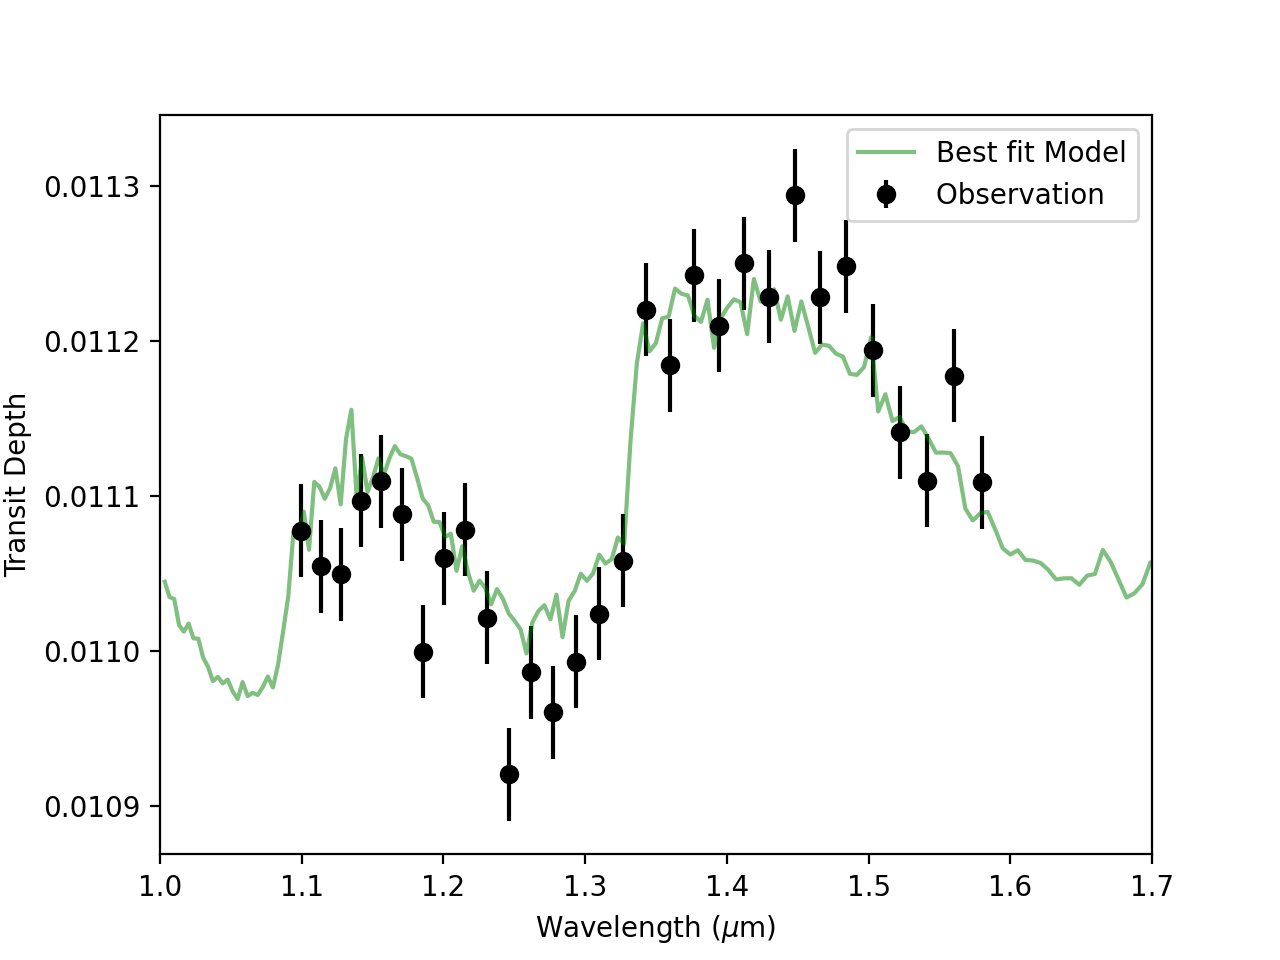

In [156]:
plt.figure()
for s in solution:
    native_spectrum = solution[s]['Spectra']['native_spectrum'][:]
    native_wavelength = solution[s]['Spectra']['native_wlgrid'][:]
    
    grid = create_grid_res(300, 1.0, 1.7)
    fb = FluxBinner(grid[:,0], grid[:,1])
    out = fb.bindown(native_wavelength, native_spectrum)
    
    plt.errorbar(obs.wavelengthGrid, obs.spectrum, obs.errorBar, fmt='o', label='Observation ', color='black')
    plt.plot(out[0],out[1],label='Best fit Model', color='green', alpha=0.5)

plt.xlim(1,1.7)
plt.legend()
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit Depth')
plt.show()

The ``solution`` variable is a standard dictionnary and the outputs can be explored using ``.keys()``:

In [157]:
## Many other outputs are available.
print(solution['solution0'].keys())
print(solution['solution0']['fit_params'].keys())

dict_keys(['Statistics', 'fit_params', 'tracedata', 'weights', 'Spectra', 'Profiles', 'derived_params'])
dict_keys(['planet_radius', 'T', 'log_metallicity', 'log_clouds_pressure'])


The world famous corner plots can be produced easilly using the ``corner`` library. It is included as part of TauREx 3.1. All that is needed is the ``tracedata`` and the ``weights`` of the samples. Here is how you would extract this:

In [158]:
from taurex.plot.corner import corner
tracedata = solution['solution0']['tracedata'][:]
weights = solution['solution0']['weights'][:]
latex_names = list(solution['solution0']['fit_params'].keys())

And now the corner plot:

<IPython.core.display.Javascript object>


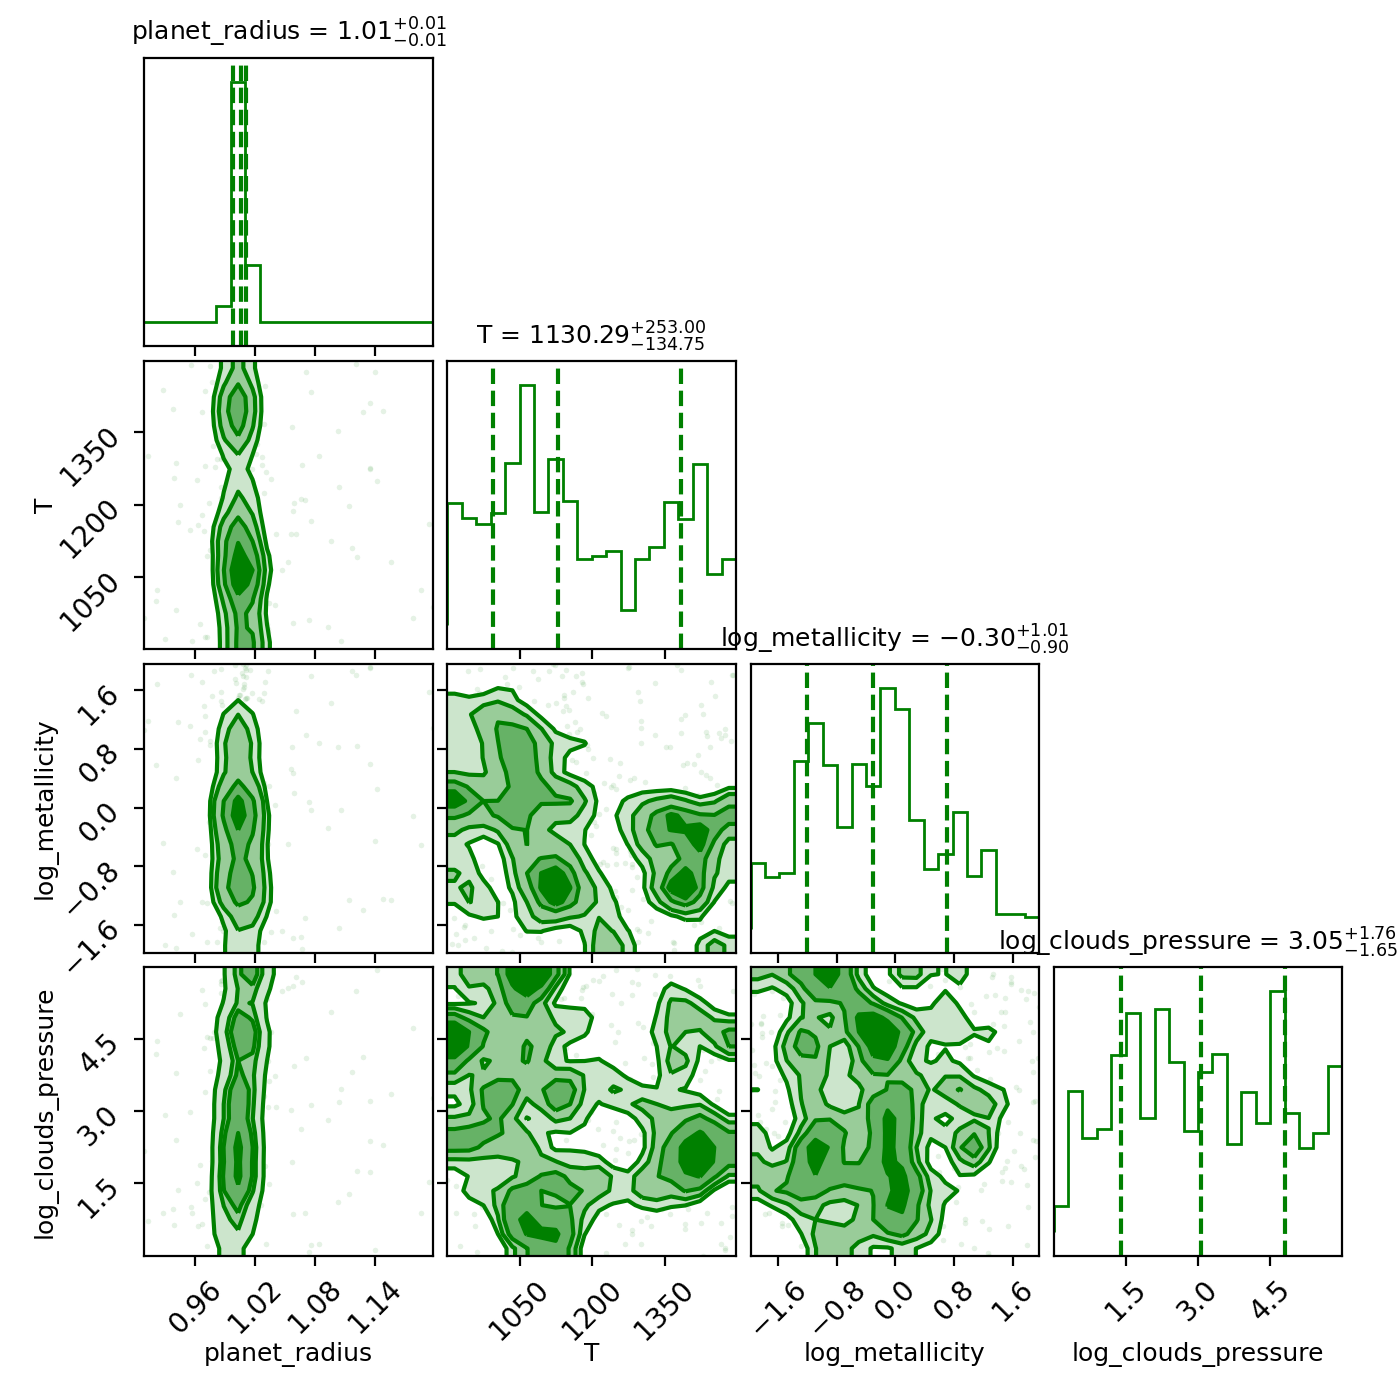

In [165]:
fig, ax = plt.subplots(len(tracedata[0,:]),len(tracedata[0,:]),figsize=(7,7))
fig =  corner(tracedata,
            weights=weights,
            labels=latex_names,
            label_kwargs=dict(fontsize=9),
            smooth=True,
            scale_hist=True,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_kwargs=dict(fontsize=9),
            ret=True,
            fill_contours=True,
            color='green',
            top_ticks=False,
            fig = fig)

As clearly visible in the previous plot, the posteriors are not very precise. This retrieval would gain a lot by increasing the number of live points to let's say 200.